Uso de Random Forest para analizar datos de supervivencia y validación cruzada para la partición de los datos.

In [1]:
# Importar las librerías necesarias
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored, NoComparablePairException
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

In [2]:
# Crear un dataframe con datos ficticios
data = {
    'edad': [50, 60, 45, 70, 65, 55, 62, 59, 47, 52],  # Edad del paciente
    'tratamiento': [1, 1, 0, 1, 0, 0, 1, 0, 1, 0],    # Tratamiento: 1 = sí, 0 = no
    'tiempo': [5, 6, 6, 2, 4, 3, 6, 8, 4, 7],         # Tiempo de supervivencia en meses
    'evento': [1, 0, 1, 1, 0, 1, 0, 1, 1, 0]          # 1 si el evento (muerte) ocurrió, 0 si está censurado
}
df = pd.DataFrame(data)
df.head()  # Mostrar las primeras filas del DataFrame

,edad,tratamiento,tiempo,evento
0,50,1,5,1
1,60,1,6,0
2,45,0,6,1
3,70,1,2,1
4,65,0,4,0


In [3]:
# Crear una estructura numpy para análisis de supervivencia
# (evento, tiempo)
surv = np.array([(bool(e), t) for e, t in zip(df['evento'], df['tiempo'])],
                dtype=[('evento', 'bool'), ('tiempo', 'float')])
surv[:5]

array([( True, 5.), (False, 6.), ( True, 6.), ( True, 2.), (False, 4.)],
      dtype=[('evento', '?'), ('tiempo', '<f8')])

In [4]:
# Definir las covariables
X = df[['edad', 'tratamiento']]
X.head()  # Mostrar las primeras filas de las covariables

,edad,tratamiento
0,50,1
1,60,1
2,45,0
3,70,1
4,65,0


In [5]:
# Crear el modelo de Random Survival Forest
rsf = RandomSurvivalForest(n_estimators=100, min_samples_split=10, min_samples_leaf=5, n_jobs=-1, random_state=42)

In [6]:
# Crear la validación cruzada estratificada
kf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

In [7]:
# Crear una variable que refleje el estatus de evento para usar en StratifiedKFold
# Transformar los valores de evento para que sean 1 y 2 en lugar de 0 y 1
status_evento = df['evento'] + 1  # 0 -> 1 (censurado), 1 -> 2 (evento)
status_evento

0    2
1    1
2    2
3    2
4    1
5    2
6    1
7    2
8    2
9    1
Name: evento, dtype: int64

In [8]:
# Función para calcular el índice de concordancia en cada fold
def concordance_index(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    pred_surv = model.predict(X_test)
    return concordance_index_censored(y_test['evento'], y_test['tiempo'], pred_surv)[0]

In [9]:
# Calcular la puntuación de validación cruzada
scores = []
for train_index, test_index in kf.split(X, status_evento):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = surv[train_index], surv[test_index]
    
    # Asegurarse de que el conjunto de entrenamiento tiene eventos
    if np.sum(y_train['evento']) > 0 and np.sum(y_test['evento']) > 0:
        try:
            score = concordance_index(rsf, X_train, y_train, X_test, y_test)
            scores.append(score)
        except NoComparablePairException:
            scores.append(np.nan)
    else:
        scores.append(np.nan)

In [10]:
# Mostrar los resultados
print(f"Índice de concordancia para cada fold: {scores}")
print(f"Índice de concordancia promedio: {np.nanmean(scores)}")

Índice de concordancia para cada fold: [0.5, 0.5, nan, 0.5]
Índice de concordancia promedio: 0.5


In [11]:
# Entrenar el modelo en el conjunto completo para analizar la importancia de las variables
rsf.fit(X, surv)

# Calcular la importancia de las variables usando permutation_importance
result = permutation_importance(rsf, X, surv, n_repeats=10, random_state=42, n_jobs=-1)

# Crear un DataFrame para mostrar las importancias
importance_df = pd.DataFrame({
    'Variable': X.columns,
    'Importancia media': result.importances_mean,
    'Desviación estándar': result.importances_std
})

# Mostrar la importancia de las variables
print(importance_df)

      Variable  Importancia media  Desviación estándar
0         edad                0.0                  0.0
1  tratamiento                0.0                  0.0


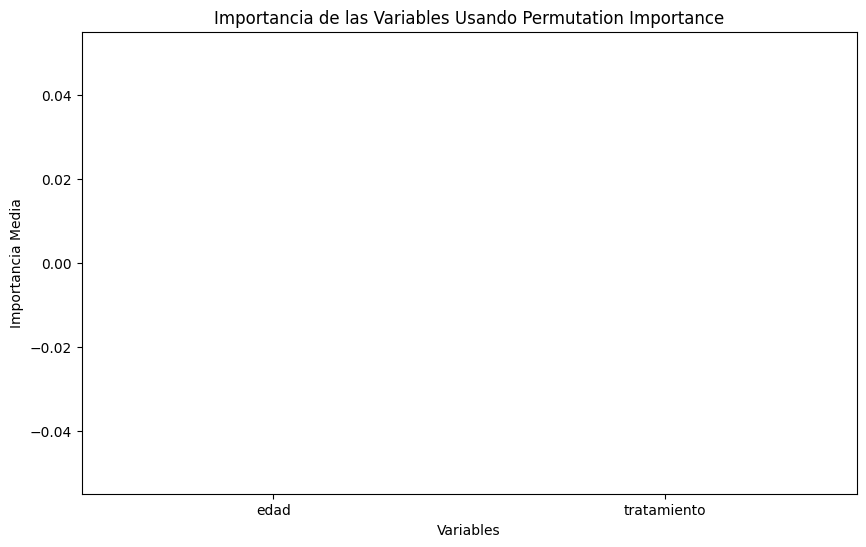

In [12]:
# Gráfico de la importancia de las variables
plt.figure(figsize=(10, 6))
plt.bar(importance_df['Variable'], importance_df['Importancia media'], yerr=importance_df['Desviación estándar'])
plt.xlabel('Variables')
plt.ylabel('Importancia Media')
plt.title('Importancia de las Variables Usando Permutation Importance')
plt.show()

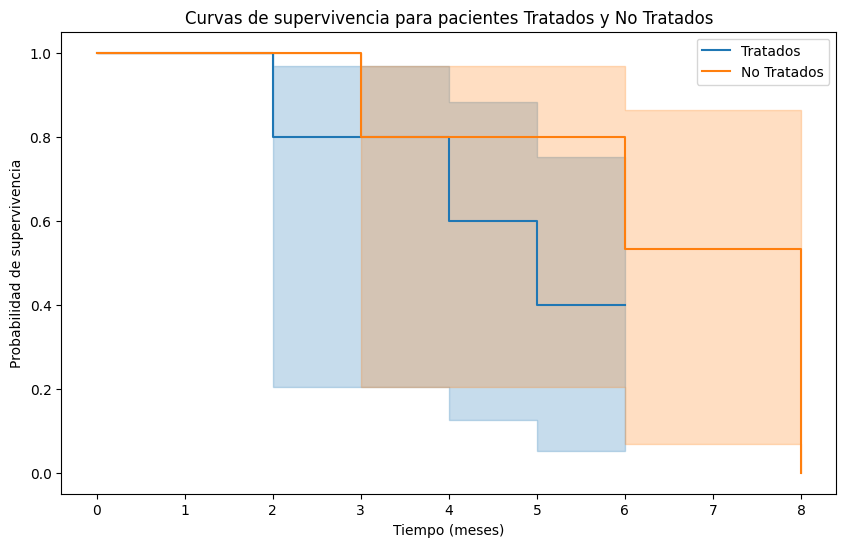

In [13]:
# Curvas de supervivencia predichas para diferentes subgrupos
# Crear un DataFrame para las predicciones
pred_surv = rsf.predict_survival_function(X)

# Separar pacientes en tratados y no tratados
tratados = df[df['tratamiento'] == 1]
no_tratados = df[df['tratamiento'] == 0]

# Crear el KaplanMeierFitter
kmf = KaplanMeierFitter()

# Graficar la curva de supervivencia para los pacientes tratados
plt.figure(figsize=(10, 6))
kmf.fit(tratados['tiempo'], event_observed=tratados['evento'], label='Tratados')
ax = kmf.plot_survival_function()

# Graficar la curva de supervivencia para los pacientes no tratados
kmf.fit(no_tratados['tiempo'], event_observed=no_tratados['evento'], label='No Tratados')
kmf.plot_survival_function(ax=ax)

plt.xlabel('Tiempo (meses)')
plt.ylabel('Probabilidad de supervivencia')
plt.title('Curvas de supervivencia para pacientes Tratados y No Tratados')
plt.legend()
plt.show()